In [1]:
import sys
sys.path.append("../lib/")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import HTML

from DalitzPhaseSpace import *
from RelBreitWigner import *

In [2]:
%matplotlib inline
rc('animation', html='html5')
rc('text', usetex=True)
plt.rc('font', size=18)

## The Breit-Wigner lineshape
### Relativistic Breit-Wigner lineshape
\begin{equation}
BW\propto\frac{1}{m_0^2 - m^2 - im\Gamma}
\end{equation}

This parameterization is implemented in the `RelBW` class.

More complex parameterization with mass-dependent width $\Gamma(m)$ is commonly used. It is implemented in the `VarWidthRelBW` class. Formalism is described below.

### Mass-dependent width
The mass-dependent width is implemented in the `MassDependentWidth` class defined in `RelBreitWigner` module.
\begin{equation}
\Gamma(m) = \Gamma_0 \left(\frac{p}{p_0}\right)^{(2S+1)} \frac{m_0}{m} F^2
\end{equation}

### Blatt-Weisskopf formfactor
Formfactor $F$ is unit for a spin $0$ resonance. FF is a function of radius $r$, momenum $p$ and nominal momentum $p_0$ of the resonance
\begin{equation}
 F = \sqrt{\frac{f_S(rp_0)}{f_S(rp)}},
\end{equation}
where
\begin{equation}
 \begin{split}
 f_1(x) &= 1+x^2,\\
 f_2(x) &= 9 + 3x + x^2,\\
 f_3(x) &= 225 + 45x + 6x^2 + x^3,\\
 f_4(x) &= \left(x^2-45x+105\right)^2 + 25x(2x-21).
 \end{split}
\end{equation}

Blatt-Weisskopf formfactors are implemented in `bwff(p, p0, r, S)` function

In [3]:
def width_dep_bw(phsp, rtype, mass, width, spin, masses):
    """ BW """
    mom0 = phsp.momentum_res(mass**2, rtype)
    res = VarWidthRelBW(mass, width, spin, mom0)
    mass_sq = masses**2
    momt = phsp.momentum_res(mass_sq, rtype)
    return res(mass_sq, momt)

In [4]:
def dens(amp):
    """ Probability dencity from complex amplitude """
    return amp.real**2 + amp.imag**2

Let's make $\rho(770)$ resonance for $D^0\to K_S^0\pi^+\pi^-$ decay

In [6]:
phsp = DalitzPhaseSpace(.475, .135, .135, 1.865)
rtype = 'BC'
mass_space = limited_mass_linspace(0, 100, 1000, phsp, rtype)
mass_space_sq = mass_space**2
rho_amp = width_dep_bw(phsp, rtype, .7717, .1490, 1, mass_space)

Plot real and imag parts of the Breit-Wigner lineshape

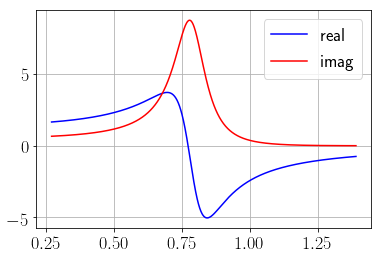

In [7]:
plt.figure()
plt.plot(mass_space, np.real(rho_amp), 'b-', label='real')
plt.plot(mass_space, np.imag(rho_amp), 'r-', label='imag')
plt.grid()
plt.legend(loc='best');

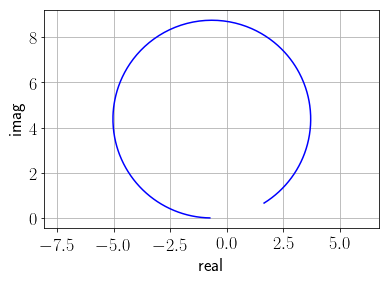

In [8]:
plt.figure()
plt.plot(np.real(rho_amp), np.imag(rho_amp), 'b-')
plt.gca().set_xlabel('real')
plt.gca().set_ylabel('imag')
plt.axis('equal')
plt.grid()

And what about the Breit-Wigner phase?

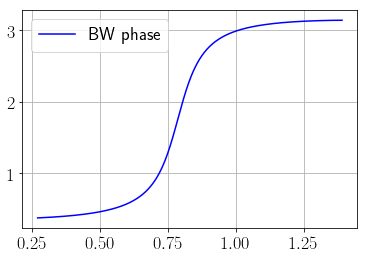

In [9]:
plt.figure()
plt.plot(mass_space, np.angle(rho_amp), 'b-', label='BW phase')
plt.grid()
plt.legend(loc='best');

## Phase space factor
Decay phase space introduces additional factor to the resonance amplitude. This factor is proportional to a width of the Dalitz plot in a given slice. For an `AB` resonance, the factor is defined by `AC` width for a given $m_{AB}^2$.

In [13]:
space_factor = phsp.phsp_factor(mass_space_sq, rtype)

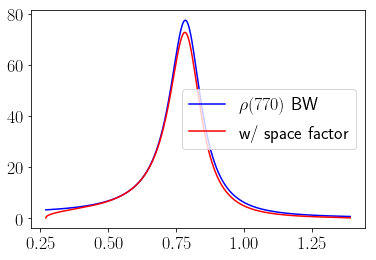

In [14]:
plt.figure()
plt.plot(mass_space, dens(rho_amp), 'b-', label=r'$\rho(770)$' + ' BW')
plt.plot(mass_space, dens(rho_amp) * space_factor, 'r-', label='w/ space factor')
plt.legend(loc='best');

## Interference
We need the second resonance. Let's take $\omega$

In [15]:
omega_amp = width_dep_bw(phsp, 'BC', .78265, .00849, 1, mass_space)

$\omega$ is much narrower than $\rho(770)$

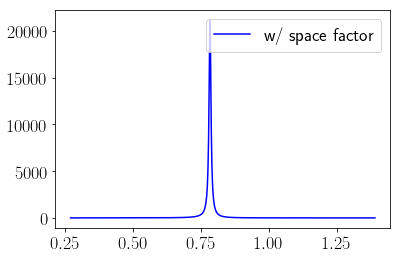

In [16]:
plt.figure()
# plt.plot(mass_space, np.abs(omega_amp), 'b-', label=r'$\omega$' + ' BW')
plt.plot(mass_space, dens(omega_amp) * space_factor, 'b-', label='w/ space factor')
plt.legend(loc='best');

### Animated interference
We set the relative amplitude of the $\omega$ resonance equal $3\%$. Do you expect significant effects in $\rho(700)$ - $\omega$ interference?

In [17]:
omega_ampl = 0.03
FIG = plt.figure()
XLIMS = (min(mass_space), max(mass_space))
YLIMS = (0, 1.05*max(dens(rho_amp + omega_ampl*omega_amp)))
AXES = plt.axes(xlim=XLIMS, ylim=YLIMS)
LINE, = AXES.plot([], [], lw=1, linestyle='-', color='blue')
plt.close()

In [18]:
def init():
    """ Init frame """
    LINE.set_data([], [])
    return LINE,

In [19]:
def animate(i):
    """ Update frame """
    ampl_omega = omega_ampl*complex(np.cos(i * np.pi / 100), np.sin(i * np.pi / 100))
    LINE.set_data(mass_space, dens(rho_amp + ampl_omega * omega_amp) * space_factor)
    return LINE,

In [20]:
def rho_omega_animated(nframes=200):
    """ Make animation! """
    anim = animation.FuncAnimation(FIG, animate, init_func=init,
                                   frames=nframes, interval=20, blit=True)
    # anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    # anim.save('basic_animation.gif', dpi=80, writer='imagemagick')
    return anim

In [21]:
rho_omega_animated(200)

### Interactive interference

In [22]:
from ipywidgets import interact
import ipywidgets as widgets

In [23]:
def animate2(angle):
    """ Update frame """
    ampl_omega = omega_ampl*complex(np.cos(angle * np.pi / 180), np.sin(angle * np.pi / 180))
    plt.axes(xlim=XLIMS, ylim=YLIMS)
    plt.plot(mass_space, dens(rho_amp + ampl_omega * omega_amp) * space_factor)
    plt.show()

In [24]:
interact(animate2, angle=widgets.IntSlider(min=-180, max=180, step=5, value=120));

interactive(children=(IntSlider(value=120, description=u'angle', max=180, min=-180, step=5), Output()), _dom_c…